In [1]:
from __future__ import print_function, division
from builtins import range

In [3]:
import gym
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from gym import wrappers
from datetime import datetime
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
import tensorflow as tf

In [4]:
def plot_running_avg(totalrewards):
  N = len(totalrewards)
  running_avg = np.empty(N)                  
  for t in range(N): 
    running_avg[t] = totalrewards[max(0, t-100):(t+1)].mean()                          
  plt.plot(running_avg)
  plt.title("Running Average")                                                                        
  plt.show()   

In [5]:
class SGDRegressor:
  def __init__(self, D):
    print("Hello TensorFlow!")
    lr = 0.1

    # create inputs, targets, params
    # matmul doesn't like when w is 1-D
    # so we make it 2-D and then flatten the prediction
    self.w = tf.Variable(tf.random_normal(shape=(D, 1)), name='w')
    self.X = tf.placeholder(tf.float32, shape=(None, D), name='X')
    self.Y = tf.placeholder(tf.float32, shape=(None,), name='Y')

    # make prediction and cost
    Y_hat = tf.reshape( tf.matmul(self.X, self.w), [-1] )
    delta = self.Y - Y_hat
    cost = tf.reduce_sum(delta * delta)

    # ops we want to call later
    self.train_op = tf.train.GradientDescentOptimizer(lr).minimize(cost)
    self.predict_op = Y_hat
  
    # start the session and initialize params
    init = tf.global_variables_initializer()
    self.session = tf.InteractiveSession()
    self.session.run(init)

  def partial_fit(self, X, Y):
    self.session.run(self.train_op, feed_dict={self.X: X, self.Y: Y})

  def predict(self, X):
    return self.session.run(self.predict_op, feed_dict={self.X: X})


In [6]:
class FeatureTransformer:                                      
  def __init__(self, env):                                     
    # observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
    # NOTE!! state samples are poor, b/c you get velocities --> infinity
    observation_examples = np.random.random((20000, 4))*2 - 1                          
    scaler = StandardScaler()      
    scaler.fit(observation_examples)           
    
    # Used to converte a state to a featurizes represenation.
    # We use RBF kernels with different variances to cover different parts of the space
    featurizer = FeatureUnion([
            ("rbf1", RBFSampler(gamma=0.05, n_components=1000)),
            ("rbf2", RBFSampler(gamma=1.0, n_components=1000)),
            ("rbf3", RBFSampler(gamma=0.5, n_components=1000)),
            ("rbf4", RBFSampler(gamma=0.1, n_components=1000))
            ]) 
    feature_examples = featurizer.fit_transform(scaler.transform(observation_examples))
    
    self.dimensions = feature_examples.shape[1]
    self.scaler = scaler
    self.featurizer = featurizer
      
  def transform(self, observations):
    scaled = self.scaler.transform(observations)
    return self.featurizer.transform(scaled)


In [7]:
# Holds one SGDRegressor for each action
class Model:
  def __init__(self, env, feature_transformer):
    self.env = env
    self.models = []
    self.feature_transformer = feature_transformer
    for i in range(env.action_space.n):
      model = SGDRegressor(feature_transformer.dimensions)
      self.models.append(model)

  def predict(self, s):
    X = self.feature_transformer.transform(np.atleast_2d(s))
    result = np.stack([m.predict(X) for m in self.models]).T
    return result

  def update(self, s, a, G):
    X = self.feature_transformer.transform(np.atleast_2d(s))
    self.models[a].partial_fit(X, [G])

  def sample_action(self, s, eps):
    if np.random.random() < eps:
      return self.env.action_space.sample()
    else:
      return np.argmax(self.predict(s))


In [8]:
def play_one(env, model, eps, gamma):
  observation = env.reset()
  done = False
  totalreward = 0
  iters = 0
  while not done and iters < 2000:
    # if we reach 2000, just quit, don't want this going forever
    # the 200 limit seems a bit early
    action = model.sample_action(observation, eps)
    prev_observation = observation
    observation, reward, done, info = env.step(action)

    if done:
      reward = -200

    # update the model
    next = model.predict(observation)
    # print(next.shape)
    assert(next.shape == (1, env.action_space.n))
    G = reward + gamma*np.max(next)
    model.update(prev_observation, action, G)

    if reward == 1: # if we changed the reward to -200
      totalreward += reward
    iters += 1

  return totalreward


In [9]:
def main():
  env = gym.make('CartPole-v0')
  ft = FeatureTransformer(env)
  model = Model(env, ft)
  gamma = 0.99

  if 'monitor' in sys.argv:
    filename = os.path.basename(__file__).split('.')[0]
    monitor_dir = './' + filename + '_' + str(datetime.now())
    env = wrappers.Monitor(env, monitor_dir)


  N = 500
  totalrewards = np.empty(N)
  costs = np.empty(N)
  for n in range(N):
    eps = 1.0/np.sqrt(n+1)
    totalreward = play_one(env, model, eps, gamma)
    totalrewards[n] = totalreward
    if n % 100 == 0:
      print("episode:", n, "total reward:", totalreward, "eps:", eps, "avg reward (last 100):", totalrewards[max(0, n-100):(n+1)].mean())

  print("avg reward for last 100 episodes:", totalrewards[-100:].mean())
  print("total steps:", totalrewards.sum())

  plt.plot(totalrewards)
  plt.title("Rewards")
  plt.show()

  plot_running_avg(totalrewards)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Hello TensorFlow!
Hello TensorFlow!


/home/ankdesh/virtualenvs/general/lib/python3.5/site-packages/tensorflow/python/client/session.py:1714: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


episode: 0 total reward: 12.0 eps: 1.0 avg reward (last 100): 12.0
episode: 100 total reward: 199.0 eps: 0.09950371902099892 avg reward (last 100): 101.0990099009901
episode: 200 total reward: 199.0 eps: 0.07053456158585983 avg reward (last 100): 189.62376237623764
episode: 300 total reward: 199.0 eps: 0.0576390417704235 avg reward (last 100): 169.16831683168317
episode: 400 total reward: 199.0 eps: 0.04993761694389223 avg reward (last 100): 189.05940594059405
avg reward for last 100 episodes: 198.96
total steps: 84644.0


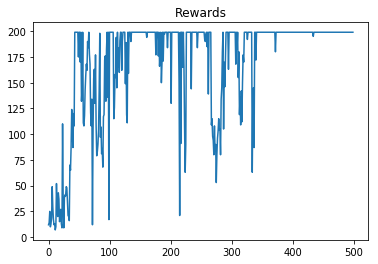

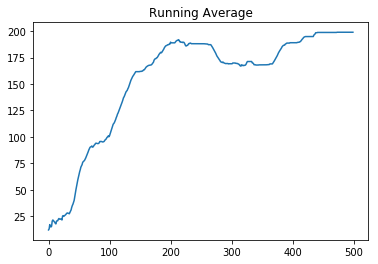

In [10]:
main()